In [1]:
import os
import datetime
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

<module 'Tracking_Visuals' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Visuals.py'>

In [2]:
# config
current_dir = os.path.dirname(os.getcwd())
dir_path = os.path.join(current_dir, 'Aalborg_Jeff') # path to directory of Tracab data
LEAGUE = 'DSL'

# Read data

In [3]:
fname = '984455'
match_id = fname

In [ ]:
# read
fpath = os.path.join(dir_path, fname, fname + '_TracDAT')
print(fpath)
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(LEAGUE, fpath, fname, verbose=True)

/Users/jeffbalkanski/research_soccer/Aalborg_Jeff/984455/984455_TracDAT
Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [28]
away goalkeeper(s):  [1]


In [ ]:
# positions
player_id_to_name = pd.read_csv('../playerid_jerseynum_map.csv')
player_id_to_name = player_id_to_name[player_id_to_name['Match ID'] == int(match_id)]
player_id_to_name.head()

In [ ]:
# add jersey num
team1_players

In [ ]:
player = team0_players[14]

# Add energy expenditure

In [39]:
import Tracking_Fatigue as fatigue

# add energy expenditure
helpers.add_to_player(team1_players, team0_players, fatigue.get_energy_expenditure, 'energy_x', skip_end=1)

Done with player 2 of team 1
Done with player 3 of team 1
Done with player 5 of team 1
Done with player 6 of team 1
Done with player 8 of team 1
Done with player 10 of team 1
Done with player 11 of team 1
Done with player 12 of team 1
Done with player 15 of team 1
Done with player 18 of team 1
Done with player 27 of team 1
Done with player 28 of team 1
Done with player 30 of team 1
Done with player 1 of team 0
Done with player 3 of team 0
Done with player 4 of team 0
Done with player 5 of team 0
Done with player 6 of team 0
Done with player 8 of team 0
Done with player 9 of team 0
Done with player 14 of team 0
Done with player 16 of team 0
Done with player 17 of team 0
Done with player 18 of team 0
Done with player 21 of team 0
Done with player 27 of team 0
Done with player 30 of team 0


In [64]:
# get series
EX = helpers.get_all_values(player, 'energy_x', start=1, skip_last=1)

In [65]:
# by position
plt.plot()

array([3.1072057 , 3.38310372, 3.94306479, ..., 0.        , 0.        ,
       0.        ])

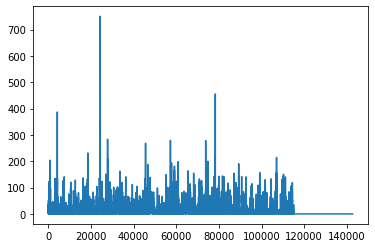

In [66]:
plt.plot(EX)